<a href="https://colab.research.google.com/github/gormantt/foursquare-location-matching/blob/main/Ling_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory data analysis

---
Data analyzed in this notebook is from [Kaggle's code competation: Foursquare - Location Matching](https://www.kaggle.com/competitions/foursquare-location-matching/data). The data comprises over one-and-a-half million place entries for hundreds of thousands of commercial Points-of-Interest (POIs) around the globe. The task is to **determine which place entries describe the same point-of-interest**. Though the data entries may represent or resemble entries for real places, they may also contain artificial information or additional noise.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

#For plotting
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

lreg = LogisticRegression()

We read the data below.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [58]:
pairs = pd.read_csv('/content/drive/MyDrive/Summer 2022/foursquare-location-matching/pairs.csv')
test = pd.read_csv('/content/drive/MyDrive/Summer 2022/foursquare-location-matching/test.csv')
train = pd.read_csv('/content/drive/MyDrive/Summer 2022/foursquare-location-matching/train.csv')

# Training data




## The data


*   `train.csv` - The training set, comprising eleven attribute fields for over one million place entries, together with:
  * `id` - A unique identifier for each entry.
  * `point_of_interest` - An identifier for the POI the entry represents. There may be one or many entries describing the same POI. Two entries "match" when they describe a common POI. 
*   `pairs.csv` - A pregenerated set of pairs of place entries from `train.csv` designed to improve detection of matches.
  * `match` - Whether (`True` or `False`) the pair of entries describes a common POI.

In [7]:
train.sample(5)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
519522,E_74c3de9e47fc30,Sosial Agency Baru,-7.781600,110.345400,Godean km. 4 No. 1,Yogyakarta,NaN,NaN,ID,NaN,NaN,Bookstores,P_a807227e6deb8f
690784,E_9b257d42dd85f2,Bugsy Hyde Beauty Salon,36.758301,-95.978806,NaN,Bartlesville,OK,74003,US,NaN,NaN,Salons / Barbershops,P_309ec089ada6a7
830111,E_ba6a24d59fab69,"Regus - Melbourne, Hawthorn",-37.823973,145.048765,Ground Floor,Hawthorn,NaN,3122,AU,http://www.regus.com.au/office-space/australia...,+61388626300,Coworking Spaces,P_6a8b53f2e08371
465448,E_68922fc0e15499,Seppälä,60.202748,24.967985,Kauppakeskus Arabia,Helsinki,NaN,00550,FI,NaN,NaN,Clothing Stores,P_e6e694fb0b5c16
722672,E_a252671bee534f,TapeOp BV,52.233260,5.168428,Borneolaan 1b,Hilversum,Noord-Holland,NaN,NL,NaN,NaN,Offices,P_05c84147a80b1f


We take a look at of how many POIs are in the data, compared to the total number of rows.

In [5]:
print('There are', len(set(train.id)), 'id, and', len(set(train.point_of_interest)), 'distinct POIs.\n')
print('About', np.round(len(set(train.point_of_interest))/len(set(train.id))*100,2),'% POIs are unique.\n')

There are 1138812 id, and 739972 distinct POIs.

About 64.98 % POIs are unique.



We take a look at the features that are available to analyze and examine the ration of missing values in the columns.

In [64]:
train.columns

Index(['id', 'name', 'latitude', 'longitude', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories', 'point_of_interest'],
      dtype='object')

In [63]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138812 entries, 0 to 1138811
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   id                 1138812 non-null  object 
 1   name               1138811 non-null  object 
 2   latitude           1138812 non-null  float64
 3   longitude          1138812 non-null  float64
 4   address            742191 non-null   object 
 5   city               839623 non-null   object 
 6   state              718226 non-null   object 
 7   zip                543386 non-null   object 
 8   country            1138801 non-null  object 
 9   url                267724 non-null   object 
 10  phone              342855 non-null   object 
 11  categories         1040505 non-null  object 
 12  point_of_interest  1138812 non-null  object 
dtypes: float64(2), object(11)
memory usage: 112.9+ MB


In [66]:
pairs.sample(5)

,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,...,longitude_2,address_2,city_2,state_2,zip_2,country_2,url_2,phone_2,categories_2,match
8119,E_03955039e944ec,El Corte Inglés,40.497774,-3.660752,"C. Margarita de Parma, 1",Madrid,Madrid,28050,ES,http://www.elcorteingles.es,...,-3.666377,"Ronda de la Comunicación, 1",NaN,NaN,NaN,ES,NaN,NaN,Department Stores,True
156924,E_452cdf6135d0a4,Kelenteng Eng An Kiong,-7.987668,112.635891,Jl. Laksamana Martadinata No. 1,Malang,East Java,NaN,ID,NaN,...,112.636000,NaN,NaN,NaN,NaN,ID,NaN,NaN,Shrines,True
411186,E_b55114999feb6d,Enil DO3,47.195343,6.162894,NaN,NaN,NaN,NaN,FR,NaN,...,6.163468,NaN,NaN,NaN,NaN,FR,NaN,NaN,NaN,True
186666,E_525384c7891ac5,İstanbul Boğazı,41.041554,29.019604,Marmara Denizi,İstanbul,Türkiye,NaN,TR,NaN,...,29.000860,NaN,NaN,NaN,NaN,TR,NaN,NaN,Boats or Ferries,True
212702,E_5dd5b9b13b690f,Pure Massage,22.320502,114.185635,80 Sheung Shing St,To Kwa Wan,NaN,NaN,HK,NaN,...,114.184073,NaN,NaN,NaN,NaN,HK,NaN,NaN,NaN,True


In [15]:
print('There are', len(pairs), 'pairs,', len(set(pairs.id_1)), 'id_1s and', len(set(pairs.id_2)), 'id_2s.\n')

There are 578907 pairs, 464765 id_1s and 565512 id_2s.



## Considering US data only

We counts the number of different countries and see that half of the data in both `train.csv` and pairs.csv are from the US.

In [68]:
pairs.country_1.value_counts()

US    117793
ID     68412
TR     61497
JP     34217
TH     31591
       ...  
YT         1
PW         1
DJ         1
SH         1
EH         1
Name: country_1, Length: 213, dtype: int64

In [69]:
train.country.value_counts()

US    245284
TR    115177
ID    110796
JP     70032
TH     58808
       ...  
BV         1
GY         1
PM         1
SS         1
VU         1
Name: country, Length: 221, dtype: int64

In [75]:
train_US = train.loc[train.country=='US']
train_US.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245284 entries, 8 to 1138808
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 245284 non-null  object 
 1   name               245283 non-null  object 
 2   latitude           245284 non-null  float64
 3   longitude          245284 non-null  float64
 4   address            188824 non-null  object 
 5   city               236241 non-null  object 
 6   state              239373 non-null  object 
 7   zip                213277 non-null  object 
 8   country            245284 non-null  object 
 9   url                99477 non-null   object 
 10  phone              131597 non-null  object 
 11  categories         232133 non-null  object 
 12  point_of_interest  245284 non-null  object 
dtypes: float64(2), object(11)
memory usage: 26.2+ MB


In [19]:
for col in train.columns:
    print('In train.csv,',"{:.6%}".format(1-len(train[col].dropna())/len(train[col])), 'rows have "NaN" for', col)

In train.csv, 0.000000% rows have "NaN" for id
In train.csv, 0.000088% rows have "NaN" for name
In train.csv, 0.000000% rows have "NaN" for latitude
In train.csv, 0.000000% rows have "NaN" for longitude
In train.csv, 34.827610% rows have "NaN" for address
In train.csv, 26.272027% rows have "NaN" for city
In train.csv, 36.931996% rows have "NaN" for state
In train.csv, 52.284837% rows have "NaN" for zip
In train.csv, 0.000966% rows have "NaN" for country
In train.csv, 76.490940% rows have "NaN" for url
In train.csv, 69.893626% rows have "NaN" for phone
In train.csv, 8.632417% rows have "NaN" for categories
In train.csv, 0.000000% rows have "NaN" for point_of_interest


In [20]:
for col in train_US.columns:
    print('In train_US.csv,',"{:.6%}".format(1-len(train_US[col].dropna())/len(train_US[col])), 'rows have "NaN" for', col)

In train_US.csv, 0.000000% rows have "NaN" for id
In train_US.csv, 0.000408% rows have "NaN" for name
In train_US.csv, 0.000000% rows have "NaN" for latitude
In train_US.csv, 0.000000% rows have "NaN" for longitude
In train_US.csv, 23.018216% rows have "NaN" for address
In train_US.csv, 3.686747% rows have "NaN" for city
In train_US.csv, 2.409860% rows have "NaN" for state
In train_US.csv, 13.048955% rows have "NaN" for zip
In train_US.csv, 0.000000% rows have "NaN" for country
In train_US.csv, 59.444155% rows have "NaN" for url
In train_US.csv, 46.349130% rows have "NaN" for phone
In train_US.csv, 5.361540% rows have "NaN" for categories
In train_US.csv, 0.000000% rows have "NaN" for point_of_interest


For this short project, there are several reasons to restrict to just the US locations (polish this):


1.   There are notably less missing values in the US locations, compared to the whole set of data.
2.   Data in most of the columns are strings and can be of different languages (**add Tim's figure**).
3.   It reduce the size of the dataset, so that it is more managable to analyze in such a short time.   



In [17]:
train_US = train.loc[train.country=='US']
pairs_US = pairs.loc[(pairs.country_1=='US') & (pairs.country_2=='US')]

In [18]:
print("{:.2%}".format(len(train_US)/len(train)),'locations are in US')
print("{:.2%}".format(len(pairs_US)/len(pairs)),'pairs are in US')

21.54% locations are in US
20.33% pairs are in US


# Features analysis

---

The features available in `test.csv` include 

```
'name', 'latitude', 'longitude', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories'
```


## latitude and longitude


---
We compute the difference for (latitude, longitude) of each pair in `pairs.csv`. It turns out 
  * locations with close (difference less than 0.001) can have have different POIs: stores are next to each other in a shopping center. In some extreme cases, places with identical coordinates can have different POI. For example, one classroom can be located vertically on top of another.  
  * conversely, locations physically far can represent the same POI, such as mountains.

In [82]:
# Compute the difference of (latitude, longitude) of each pair in pairs.csv
pairs['location_diff'] = pd.concat([(pairs['latitude_1']-pairs['latitude_2']).abs(), (pairs['longitude_1']-pairs['longitude_2']).abs()], axis=1).max(axis=1)

pairs.location_diff.describe()

count    578907.000000
mean          0.131210
std           2.964284
min           0.000000
25%           0.000316
50%           0.001111
75%           0.004946
max         270.865670
Name: location_diff, dtype: float64

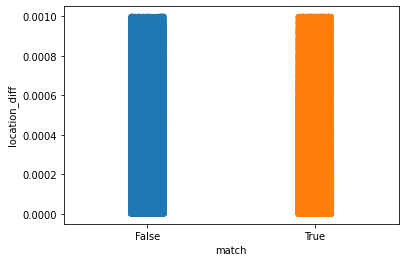

In [83]:
sns.stripplot(x="match", y="location_diff", data=pairs.loc[pairs.location_diff<0.001])
plt.show()

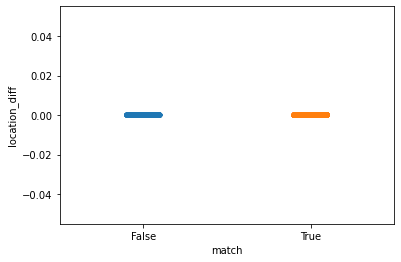

In [87]:
sns.stripplot(x="match", y="location_diff", data=pairs.loc[pairs.location_diff==0])
plt.show()

In [25]:
print('There are',len(pairs.loc[(pairs.location_diff==0) & (pairs.match==False)]),'pairs with location_diff=0 but different POIs, out of all',len(pairs),'pairs.')

There are 574 pairs with location_diff=0 but different POIs, out of all 578907 pairs.


## name

  * There are some true pairs with slightly different names, e.g. short name v.s. full name.
  * Conversely, there are false pairs with the same name, e.g. chain stores in different cities.

In [105]:
pairs.loc[pairs.match==True]

,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,...,match,location_diff,name_diff,address_diff,city_diff,state_diff,zip_diff,url_diff,phone_diff,categories_diff
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,...,True,0.009383,0.222222,-1.000000,-1.0,-1.0,-1.0,-1.0000,-1.000000,0.0000
2,E_000023d8f4be44,Island Spa,14.518970,121.018702,"5th Flr, Newport Mall, Resorts World Manila",Pasay City,Metro Manila,NaN,PH,NaN,...,True,0.001126,0.437500,-1.000000,-1.0,-1.0,-1.0,-1.0000,-1.000000,0.0000
3,E_00007dcd2bb53f,TOGO'S Sandwiches,38.257797,-122.064599,"1380 Holiday Ln., Ste. B",Fairfield,CA,94534,US,https://locations.togos.com/ll/US/CA/Fairfield...,...,True,0.000141,0.666667,-1.000000,0.0,0.0,-1.0,-1.0000,-1.000000,0.0000
5,E_0000c566a81ea1,つじ田 味噌の章,35.694796,139.767348,神田小川町1-1,千代田区,東京都,101-0052,JP,https://tsukemen-tsujita.com,...,True,0.000633,0.428571,-1.000000,-1.0,-1.0,-1.0,-1.0000,-1.000000,0.8125
6,E_0000d9e584ed9f,Signature Properties Savannah,32.012582,-81.113156,100 Commercial Ct Ste C,Savannah,GA,31406,US,http://www.oursignatureproperties.com,...,True,0.005068,0.000000,0.684211,0.0,0.0,0.0,-1.0000,-1.000000,-1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578899,E_ffff2b8abf31ab,La Tagliatella,41.390307,2.173657,C. d’Ausiàs Marc 7,Barcelona,Barcelona,08008,ES,NaN,...,True,0.000038,0.000000,0.400000,0.0,0.0,0.4,-1.0000,0.666667,0.0000
578901,E_ffff7b1a22e81b,Sorrento,37.540007,127.070265,NaN,NaN,NaN,NaN,KR,NaN,...,True,0.000245,0.000000,-1.000000,-1.0,-1.0,-1.0,-1.0000,-1.000000,0.0000
578902,E_ffff80f94b2fee,Blk 332 Hougang Avenue 5,1.368397,103.898145,332 Hougang Ave 5,Singapore,Singapore,530332,SG,NaN,...,True,0.000693,0.600000,0.214286,-1.0,-1.0,-1.0,-1.0000,-1.000000,-1.0000
578904,E_ffff989ae206f8,Cricket Wireless Authorized Retailer,36.130623,-86.715636,825C Murfreesboro Pike,Nashville,TN,37217,US,https://www.cricketwireless.com/stores/ll/US/T...,...,True,0.008220,0.000000,0.000000,0.0,0.0,0.0,0.6125,0.000000,0.0000


In [97]:
pairs.loc[pairs.match==True].values[0]

array(['E_000001272c6c5d', 'Café Stad Oudenaarde', 50.85997533509319,
       3.6341963487748346, 'Abdijstraat', 'Nederename', 'Oost-Vlaanderen',
       '9700', 'BE', nan, nan, 'Bars', 'E_da7fa3963561f8',
       'Café Oudenaarde', 50.869358, 3.635206, nan, nan, nan, nan, 'BE',
       nan, nan, 'Bars', True, 0.009382664906809168, 0.2222222222222222,
       -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0], dtype=object)

In [110]:
pairs.loc[(pairs.name_1==pairs.name_2)&(pairs.name_1=="McDonald's")&(pairs.match==True)]

,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,...,match,location_diff,name_diff,address_diff,city_diff,state_diff,zip_diff,url_diff,phone_diff,categories_diff
673,E_0054712d9d9857,McDonald's,41.804347,-88.046846,2535 Ogden Ave,Downers Grove,IL,60515,US,https://www.mcdonalds.com/us/en-us/location/il...,...,True,0.095824,0.0,0.000000,0.000000,0.0,0.0,-1.000000,-1.000000,0.421053
3080,E_016131fbea3143,McDonald's,4.397131,113.993632,Bintang Megamall,Miri,Sarawak,98000,MY,http://www.mcdonalds.com.my,...,True,0.001832,0.0,0.933333,0.000000,0.0,-1.0,-1.000000,-1.000000,0.000000
3429,E_018242e69010d0,McDonald's,41.651158,-88.124151,675 N Weber Rd,Romeoville,IL,60446,US,https://www.mcdonalds.com/us/en-us/location/il...,...,True,0.050548,0.0,0.000000,0.000000,0.0,0.0,0.759036,0.166667,0.000000
3859,E_01b55e74db2bd0,McDonald's,40.496083,-80.246145,Airside Terminal,Pittsburgh,PA,15231,US,https://www.mcdonalds.com/us/en-us/location/pa...,...,True,0.000452,0.0,0.533333,1.000000,0.0,0.6,-1.000000,-1.000000,0.000000
4089,E_01cf1c6c123904,McDonald's,14.243853,121.059211,Sta Rosa - Tagaytay Rd,City of Santa Rosa,Laguna,4026,PH,NaN,...,True,0.000730,0.0,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572265,E_fd13ee41a7baab,McDonald's,51.588900,-3.210642,CROSSWAYS PARK,Caerphilly,NaN,CF83 3NL,GB,http://www.mcdonalds.co.uk,...,True,0.000323,0.0,0.153846,0.000000,-1.0,0.0,0.000000,0.230769,0.000000
574446,E_fe0f3aedff7524,McDonald's,43.687579,-79.286688,2480 Gerrard Street East,Scarborough,ON,M1N 4C3,CA,https://www.mcdonalds.com/ca/en-ca/restaurant-...,...,True,0.005950,0.0,-1.000000,0.727273,0.0,-1.0,0.790909,-1.000000,0.000000
575895,E_feab7256c7facf,McDonald's,45.961757,-66.643384,King's Place,Fredericton,NB,NaN,CA,http://www.mcdonalds.ca,...,True,0.000232,0.0,0.615385,0.000000,0.0,-1.0,0.603448,-1.000000,0.406250
576761,E_ff198dad8046e8,McDonald's,31.505339,-87.318019,1511 S Alabama Ave,Monroeville,AL,36460,US,https://www.mcdonalds.com/us/en-us/location/al...,...,True,0.009555,0.0,0.000000,0.000000,0.0,0.0,-1.000000,-1.000000,0.000000


In [112]:
pairs.loc[(pairs.name_1==pairs.name_2)&(pairs.name_1=="McDonald's")&(pairs.match==True)].values[0]

array(['E_0054712d9d9857', "McDonald's", 41.80434733686549,
       -88.04684628582879, '2535 Ogden Ave', 'Downers Grove', 'IL',
       '60515', 'US',
       'https://www.mcdonalds.com/us/en-us/location/il/downers-grove/2535-ogden-ave/36793.html',
       '+16309647433', 'Fast Food Restaurants', 'E_3d2134a9e1c29a',
       "McDonald's", 41.802858161557765, -88.14267043789413,
       '2535 Ogden Ave', 'Downers Grove', 'IL', '60515', 'US', nan, nan,
       'American Restaurants', True, 0.09582415206533312, 0.0, 0.0, 0.0,
       0.0, 0.0, -1.0, -1.0, 0.42105263157894735], dtype=object)

## address

### street address

### city

### state

### zip

### country

## url


## phone

## categories

## Comparing string features

Most columns in this data are strings. We consider different metrics for string comparison, including:


*   SequenceMatcher
*   Levenshtein distance
*   CountVectorizer
*   cosine_similarity

If one value of a pair of features is missing, we set the distance to be -1.



In [28]:
from difflib import SequenceMatcher
import math
# Reference: https://stackoverflow.com/questions/43916271/python-pandas-sequencematch-columns-for-each-value-and-return-closet-match

def seq_metric(df, col1, col2):
    a = df[col1]
    b = df[col2]
    
    if type(a)!=str or type(b)!=str:
        return -1
    else:
        a = a.lower().replace(" ", "").replace("'", "")
        b = b.lower().replace(" ", "").replace("'", "")
        
    return 1-SequenceMatcher(None, a, b).ratio()

In [34]:
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 2.9 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149855 sha256=de660eb3c2f228f08674aef8fcefc5bfa18b2a3240ff4e29f0469539ee282ce2
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [35]:
from Levenshtein import distance as lev
def lev_metric(df, col1, col2):
    a = df[col1]
    b = df[col2]
    
    if type(a)!=str or type(b)!=str:
        return -1
    else:
        a = a.lower().replace(" ", "").replace("'", "")
        b = b.lower().replace(" ", "").replace("'", "")
    #if a in b or b in a: 
    #    return 0
    return lev(a,b)/max(len(a),len(b))

In [88]:
from sklearn.feature_extraction.text import CountVectorizer

coun_vect=CountVectorizer()

def countvec_metric(df, col1, col2):
    a = df[col1]
    b = df[col2]
    if type(a)!=str or type(b)!=str:
        return -1
    else:
        count_matrix=coun_vect.fit_transform([a,b])
    return np.count_nonzero(count_matrix.toarray()[0]!=count_matrix.toarray()[1])/len(count_matrix.toarray()[0])

The following function allows us to apply different metric on the columns of pairs.csv to generate distance between features.

In [27]:
def compute_diffs(df, cols, string_metric):
    df_copy = df
    for col in cols:
        df_copy[col+'_diff'] = df.apply(string_metric,
                          args=(col+'_1', col+'_2'),
                          axis=1)
    return df_copy[ ['id_1','id_2','match']+['location_diff']+ [col+'_diff' for col in cols] ]

In [91]:
# Using SequenceMatcher

columns = ['name', 'address', 'city', 'state',
       'zip', 'url', 'phone', 'categories']
       
pairs_seq = compute_diffs(pairs, columns, seq_metric)

In [92]:
# Using Levenshtein distance

columns = ['name', 'address', 'city', 'state',
       'zip', 'url', 'phone', 'categories']
       
pairs_lev = compute_diffs(pairs, columns, lev_metric)

### Histogram

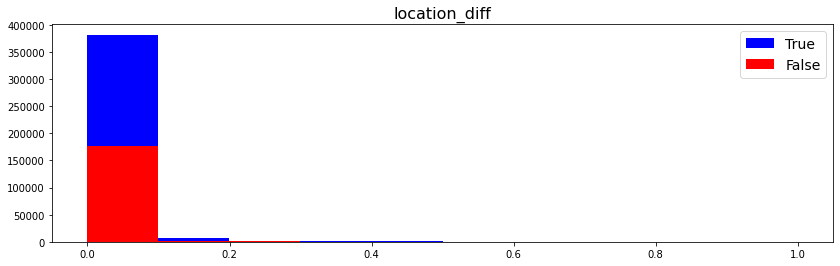

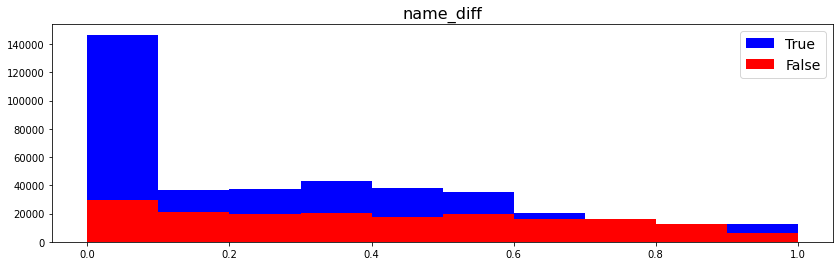

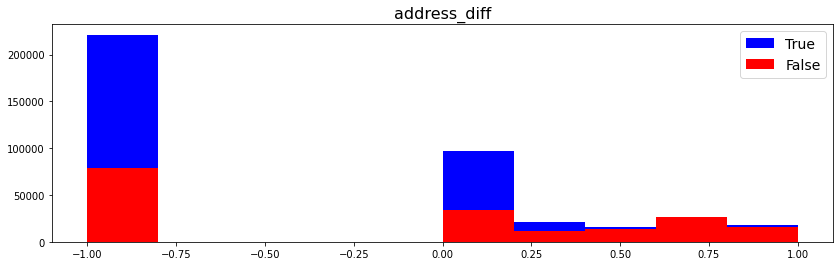

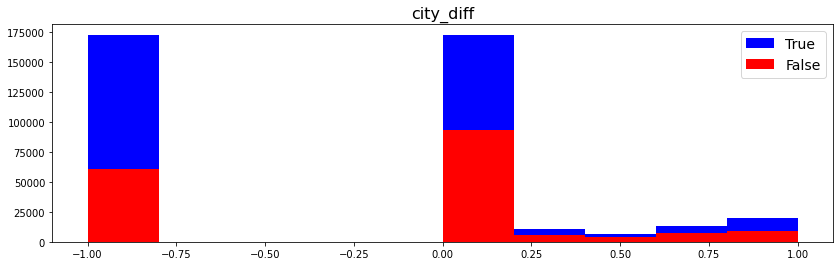

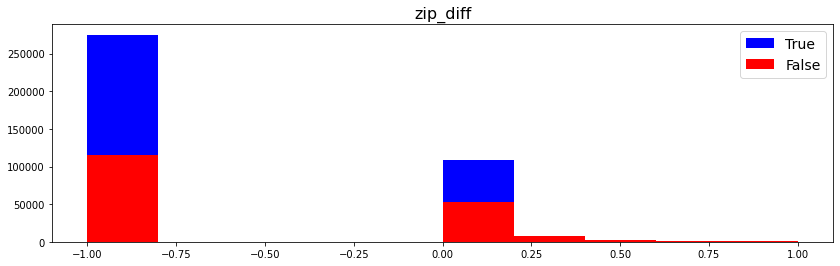

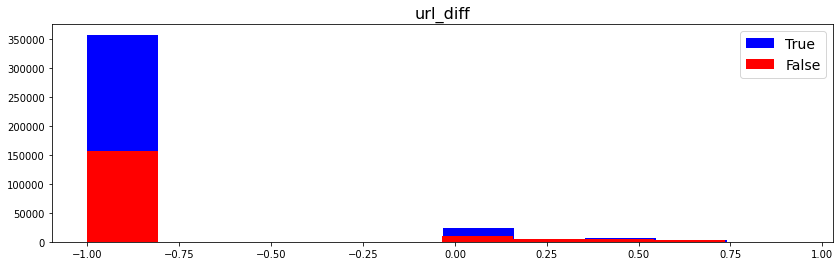

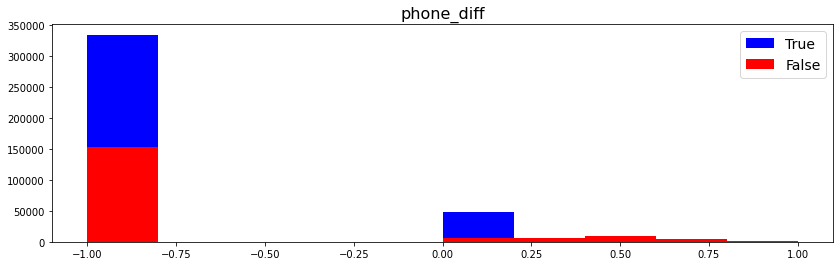

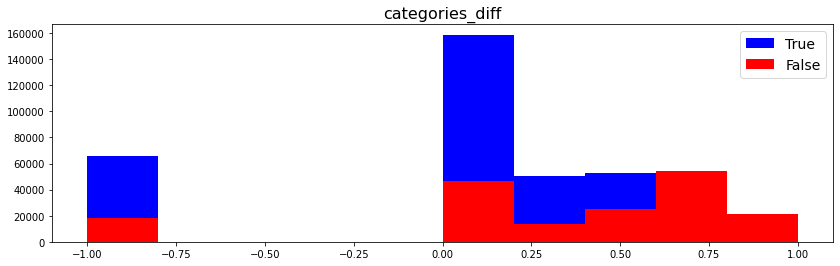

In [30]:
## histograms for SequenceMatcher

for column in ['location_diff','name_diff','address_diff','city_diff','zip_diff','url_diff', 'phone_diff', 'categories_diff']:
    plt.figure(figsize=(14,4))
    plt.hist(pairs_seq.loc[(pairs_seq.match==True)&(pairs_seq.location_diff<1), column], color='b', label="True")
    plt.hist(pairs_seq.loc[(pairs_seq.match==False)&(pairs_seq.location_diff<1), column], color='r', label="False")
    plt.legend(fontsize=14)
    plt.title(column,fontsize=16)
    plt.show()

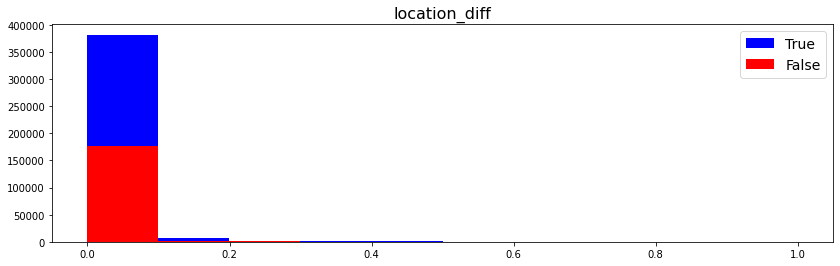

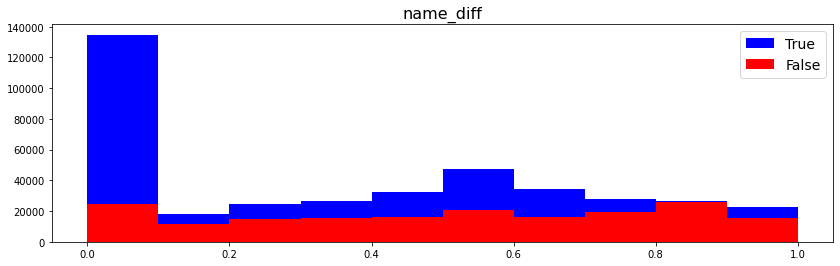

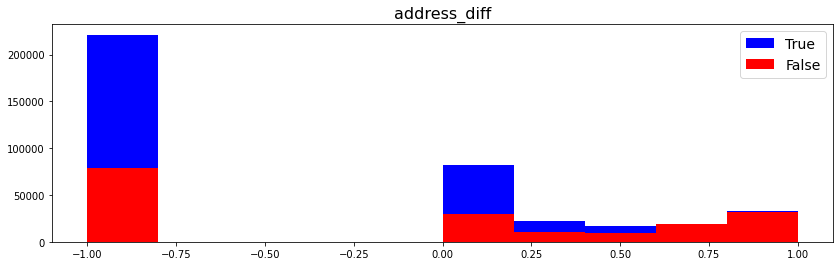

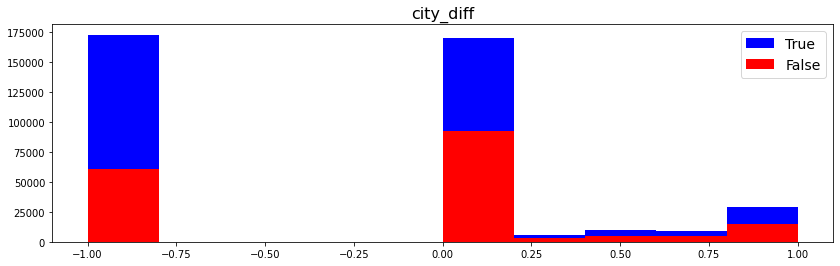

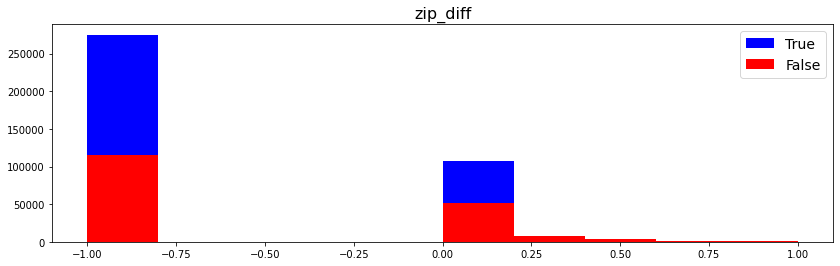

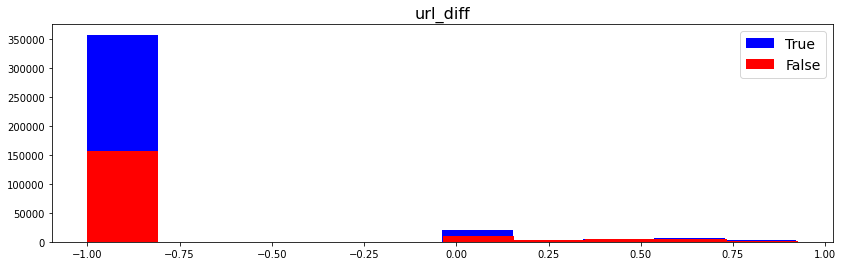

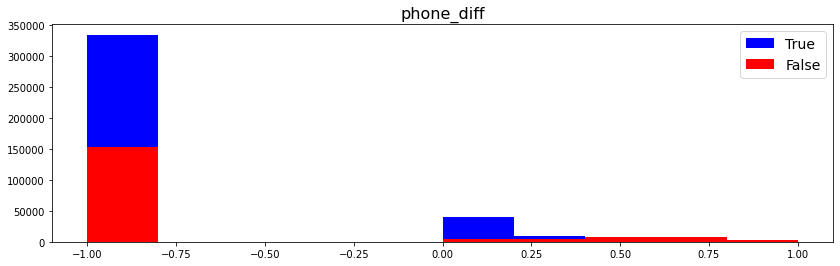

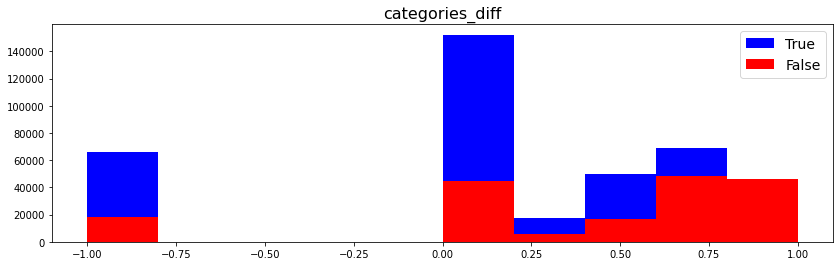

In [37]:
# Histogram for Levenshtein distance
for column in ['location_diff','name_diff','address_diff','city_diff','zip_diff','url_diff', 'phone_diff', 'categories_diff']:
    plt.figure(figsize=(14,4))
    plt.hist(pairs_lev.loc[(pairs_lev.match==True)&(pairs_lev.location_diff<1), column], color='b', label="True")
    plt.hist(pairs_lev.loc[(pairs_lev.match==False)&(pairs_lev.location_diff<1), column], color='r', label="False")
    plt.legend(fontsize=14)
    plt.title(column,fontsize=16)
    plt.show()

## Logistic regression

In [31]:
cols = ['location_diff','name_diff','address_diff','city_diff','zip_diff','url_diff', 'phone_diff', 'categories_diff']

columns = [ cols[1:i+2] for i in range(len(cols)-1)]

scores=[]

for cols in columns:
    pairs_copy=pairs_seq[['match']+cols]

    train,test=train_test_split(pairs_copy, test_size=.2, random_state=0)

    X_train = train[cols]
    X_test = test[cols]

    y_train = train['match']
    y_test = test['match']

    lreg = LogisticRegression()
    lreg.fit(X_train,y_train)

    y_pred = lreg.predict(X_test)

    confusion_matrix(y_test,y_pred)
    scores.append(roc_auc_score(y_test,y_pred))

print(scores)

[0.5086643245744975, 0.5702194978810758, 0.5692732510218169, 0.5717358411310232, 0.571723497620161, 0.5705825343142642, 0.5933675913331048]


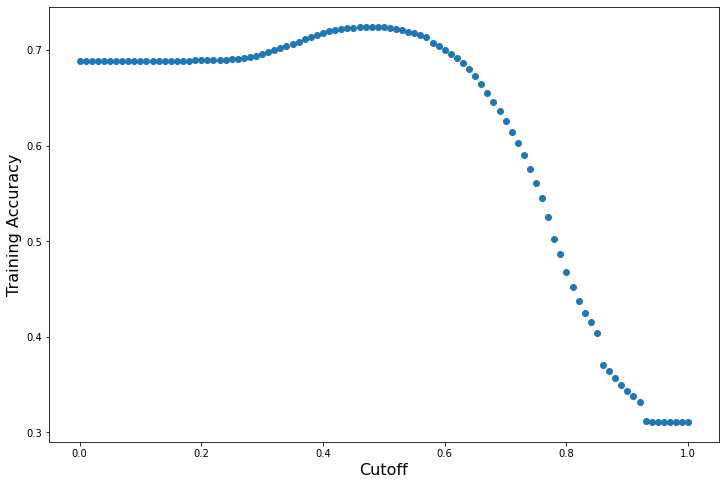

In [32]:
## set the cutoff
cutoff = 0.8

cols = ['location_diff','name_diff','address_diff','city_diff','zip_diff','url_diff', 'phone_diff', 'categories_diff']

pairs_copy=pairs_seq[['match']+cols]
train, test=train_test_split(pairs_copy, test_size=.2, random_state=0)

X_train = train[cols]
X_test = test[cols]
y_train = train['match']
y_test = test['match']

lreg = LogisticRegression(C=1)
lreg.fit(X_train,y_train)

## store the predicted probabilities
y_prob = lreg.predict_proba(X_train)[:,1]

#y_pred = lreg.predict(X_test)
#confusion_matrix(y_test,y_pred)
#scores.append(roc_auc_score(y_test,y_pred))

## Now plot how the accuracy changes with the cutoff
cutoffs = np.arange(0,1.01,.01)
accs = []

for cutoff in cutoffs:
    y_train_pred = 1*(y_prob >= cutoff)
    accs.append(np.sum(y_train_pred == y_train)/len(y_train))

plt.figure(figsize=(12,8))

plt.scatter(cutoffs,accs)

plt.xlabel("Cutoff",fontsize=16)
plt.ylabel("Training Accuracy",fontsize=16)

plt.show()

In [33]:
print('The percentage of true matches is',"{:.2%}".format(pairs.match.value_counts()[1]/len(pairs)))

The percentage of true matches is 68.89%


## Baseline

In [53]:
def baseline(df, cols, threshold):
    df_copy = df
    for col in cols:
        df_copy.match[(df_copy.col<threshold) & (df_copy.col>=0)] = True

In [55]:
cols = ['location_diff','name_diff','address_diff']
threshold = 0.1

y_pred_seq = baseline(pairs_seq, cols, threshold).match

AttributeError: ignored

In [36]:
columns = ['name', 'address', 'city', 'state', 'zip', 'url', 'phone', 'categories']
       
pairs_lev = compute_diffs(pairs, columns, lev_metric)

### Histogram

In [38]:
cols = ['location_diff','name_diff','address_diff','city_diff','zip_diff','url_diff', 'phone_diff', 'categories_diff']
cols[:len(cols)]

['location_diff',
 'name_diff',
 'address_diff',
 'city_diff',
 'zip_diff',
 'url_diff',
 'phone_diff',
 'categories_diff']

## Logistic regression

In [39]:
cols = ['location_diff','name_diff','address_diff','city_diff','zip_diff','url_diff', 'phone_diff', 'categories_diff']

columns = [ cols[:i+2] for i in range(len(cols)-1)]

scores=[]
for cols in columns:
    pairs_copy=pairs_lev[['match']+cols]

    train, test=train_test_split(pairs_copy, test_size=.2, random_state=0)

    X_train = train[cols]
    X_test = test[cols]

    y_train = train['match']
    y_test = test['match']

    lreg = LogisticRegression(C=1)
    lreg.fit(X_train,y_train)

    y_pred = lreg.predict(X_test)

    confusion_matrix(y_test,y_pred)
    scores.append(roc_auc_score(y_test,y_pred))

print(scores)

[0.5, 0.5647949494797362, 0.5654369340355991, 0.5696772493308961, 0.5700608527213438, 0.5688630421182831, 0.5890845677091827]


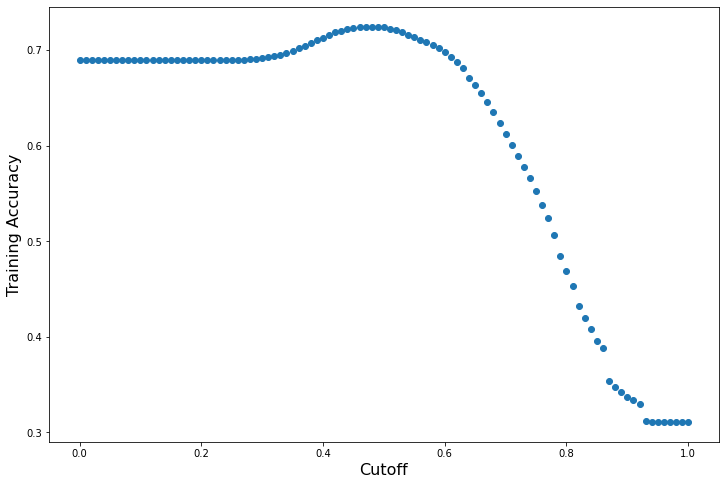

0.7243638326585695

In [40]:
## set the cutoff
cutoff = 0.8

cols = ['location_diff','name_diff','address_diff','city_diff','zip_diff','url_diff', 'phone_diff', 'categories_diff']

pairs_copy=pairs_lev[['match']+cols]
train, test=train_test_split(pairs_copy, test_size=.2, random_state=0)

X_train = train[cols]
X_test = test[cols]
y_train = train['match']
y_test = test['match']

lreg = LogisticRegression(C=1)
lreg.fit(X_train,y_train)

## store the predicted probabilities
y_prob = lreg.predict_proba(X_train)[:,1]

#y_pred = lreg.predict(X_test)
#confusion_matrix(y_test,y_pred)
#scores.append(roc_auc_score(y_test,y_pred))

## Now plot how the accuracy changes with the cutoff
cutoffs = np.arange(0,1.01,.01)
accs = []

for cutoff in cutoffs:
    y_train_pred = 1*(y_prob >= cutoff)
    accs.append(np.sum(y_train_pred == y_train)/len(y_train))

plt.figure(figsize=(12,8))
plt.scatter(cutoffs,accs)
plt.xlabel("Cutoff",fontsize=16)
plt.ylabel("Training Accuracy",fontsize=16)

plt.show()

max(accs)

## Threshoding location_diff

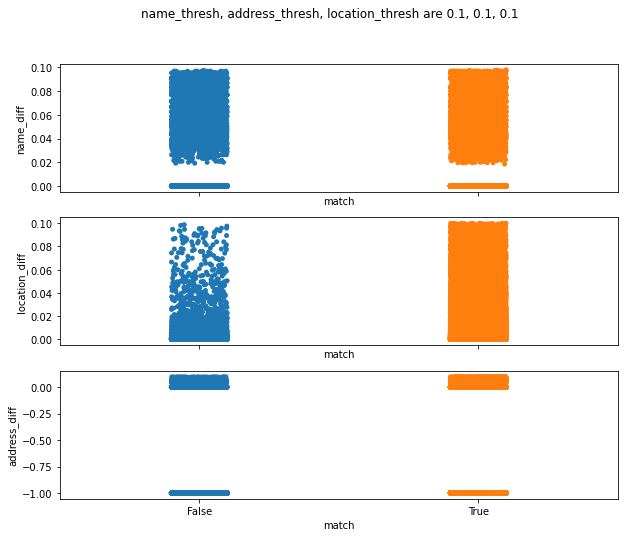

(True     0.911419
 False    0.088581
 Name: match, dtype: float64, 0.17724263137256935)

In [41]:
name_thresh, address_thresh, location_thresh = 0.1,0.1,0.1
cols = ['name_diff','location_diff', 'address_diff']

df = pairs_lev.loc[(pairs_lev.name_diff<name_thresh)&(pairs_lev.address_diff<address_thresh)&(pairs_lev.location_diff<location_thresh)]

fig,ax = plt.subplots(3,1, figsize=(10,8), sharex=True)

fig.suptitle('name_thresh, address_thresh, location_thresh are 0.1, 0.1, 0.1')

for i in range(len(cols)):
    sns.stripplot(x="match", y=cols[i], data=df, ax=ax[i])

plt.show()

df.match.value_counts()/len(df), len(df)/len(pairs_lev)

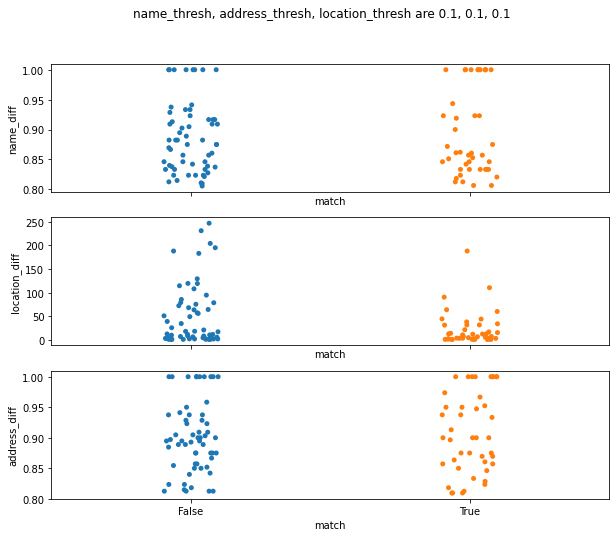

False    0.578431
True     0.421569
Name: match, dtype: float64

In [42]:
name_thresh, address_thresh, location_thresh = 0.8,0.8,0.8
cols = ['name_diff','location_diff', 'address_diff']

df = pairs_lev.loc[(pairs_lev.name_diff>name_thresh)&(pairs_lev.address_diff>address_thresh)&(pairs_lev.location_diff>location_thresh)]

fig,ax = plt.subplots(3,1, figsize=(10,8), sharex=True)

fig.suptitle('name_thresh, address_thresh, location_thresh are 0.1, 0.1, 0.1')

for i in range(len(cols)):
    sns.stripplot(x="match", y=cols[i], data=df, ax=ax[i])

plt.show()

df.match.value_counts()/len(df)

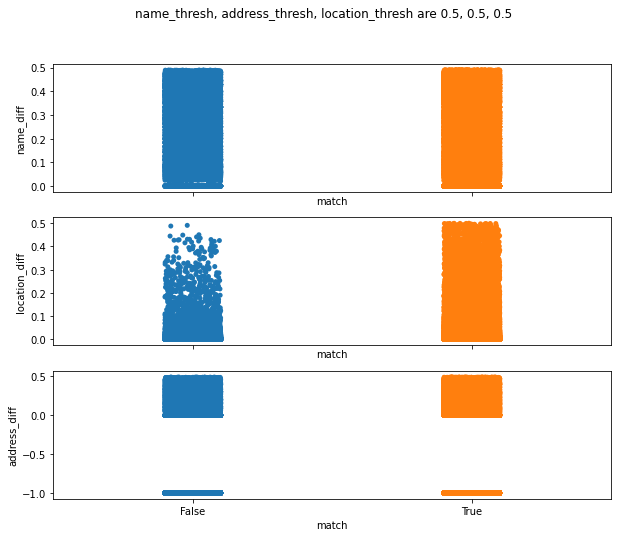

True     0.776838
False    0.223162
Name: match, dtype: float64

In [43]:
name_thresh, address_thresh, location_thresh = 0.5, 0.5, 0.5
cols = ['name_diff','location_diff', 'address_diff']

df = pairs_lev.loc[(pairs_lev.name_diff<name_thresh)&(pairs_lev.address_diff<address_thresh)&(pairs_lev.location_diff<location_thresh)]

fig,ax = plt.subplots(3,1, figsize=(10,8), sharex=True)

fig.suptitle('name_thresh, address_thresh, location_thresh are 0.5, 0.5, 0.5')

for i in range(len(cols)):
    sns.stripplot(x="match", y=cols[i], data=df, ax=ax[i])

plt.show()

df.match.value_counts()/len(df)

In [44]:
pairs.loc[pairs.id_1=='E_00efc97ecd2a98'].values

array([['E_00efc97ecd2a98', 'Greek From Greece', 40.75195022641434,
        -73.99019108026202, nan, 'New York', 'NY', '10018', 'US', nan,
        nan, 'Greek Restaurants', 'E_b213a99b54954a',
        'Greek From Greece', 40.759575, -73.989365, '45 W 45th St',
        'New York', 'NY', '10036', 'US', nan, nan, 'Cafés', False,
        0.00762477358566116, 0.0, -1.0, 0.0, 0.4, -1.0, -1.0, 0.875, 0.0]],
      dtype=object)

In [45]:
len(pairs_lev)

578907

# To improve (to be polished)



1.   Generate more pairs: mention how many pairs there are blabla
2.   Consider places in other countries blabla
3.   Filling in missing values: for example, zip codes can be obtained from the coordinates.
4.   Balance the dataset: change the ratio of true/false pairs blabla.





# Old notes

### Name

---

We compute the difference for names of each pair in `pairs.csv`. 

In [ ]:
pairs['name_diff'] = pairs.apply(sim_metric,
                          args=('name_1', 'name_2'),
                          axis=1)

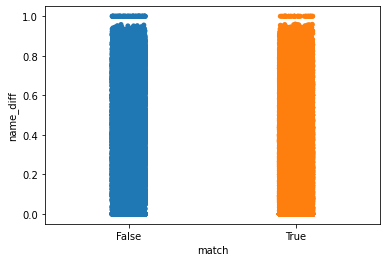

In [ ]:
sns.stripplot(x="match", y="name_diff", data=pairs)
plt.show()

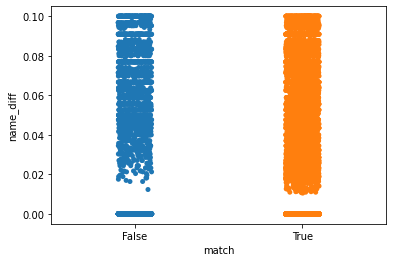

In [ ]:
sns.stripplot(x="match", y="name_diff", data=pairs.loc[pairs.name_diff<0.1])
plt.show()

In [ ]:
pairs.loc[(pairs.location_diff<0.01)&(pairs.name_diff==0)&(pairs.match==False)][['name_1','name_2']]

,name_1,name_2
702,Panera Bread,Panera Bread
755,Starbucks,Starbucks
849,Wingstop,Wingstop
1071,Bank of America,Bank of America
1403,AT&T U-verse,AT&T U-verse
...,...,...
577660,Dunkin',Dunkin'
577867,Jimmy John's,Jimmy John's
578340,Starbucks,Starbucks
578407,XFINITY Store by Comcast,XFINITY Store by Comcast


### Address

In [ ]:
pairs['address_diff'] = pairs.apply(sim_metric,
                          args=('address_1', 'address_2'),
                          axis=1)

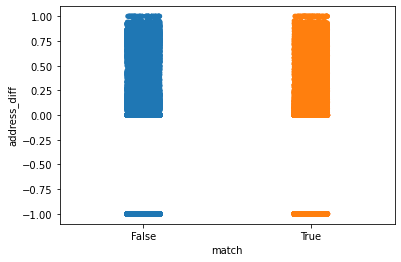

In [ ]:
sns.stripplot(x="match", y="address_diff", data=pairs)
plt.show()

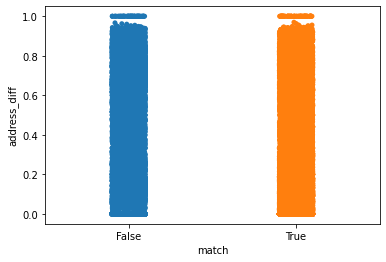

In [ ]:
sns.stripplot(x="match", y="address_diff", data=pairs.loc[pairs.address_diff>=0])
plt.show()

In [ ]:
pairs.loc[(pairs.location_diff<0.01)&(pairs.name_diff<0.1)&(pairs.address_diff==0)&(pairs.match==False)&(pairs.country_1=='US')][['name_1','name_2','address_1','address_2']]

,name_1,name_2,address_1,address_2
532,Parkview High School Building H,Parkview High School Building C,"998 Cole Dr, Lilburn, GA 30047","998 Cole Dr, Lilburn, GA 30047"
2526,Sprague Lake Rest Area (Westbound),Sprague Lake Rest Area (Eastbound),Interstate 90,Interstate 90
5315,Section 304,Section 305,KeyBank Center,KeyBank Center
5316,Section 304,Section 308,KeyBank Center,KeyBank Center
6259,Facebook 1050 Building 2,Facebook 1050 Building 1,1050 Page Mill Rd,1050 Page Mill Rd
...,...,...,...,...
571522,Conference Room HS 2007,Conference Room HS 2038,Health Information and Translational Science (HS),Health Information and Translational Science (HS)
572791,Mann Center for the Performing Arts,Mann Center for the Performing Arts D Gate,5201 Parkside Ave,5201 Parkside Ave
575350,Pozez Education Center Centennial D,Pozez Education Center Centennial A,1505 SW 8th Ave,1505 SW 8th Ave
576064,UCF Business Administration II (BA2),UCF Business Administration I (BA1),4000 Central Florida Blvd,4000 Central Florida Blvd


In [ ]:
pairs.match.value_counts()

True     84611
False    33097
Name: match, dtype: int64

In [ ]:
pairs.loc[pairs.location_diff<1].match.value_counts()

True     83822
False    33006
Name: match, dtype: int64

### City

In [ ]:
pairs['city_diff'] = pairs.apply(sim_metric,
                          args=('city_1', 'city_2'),
                          axis=1)

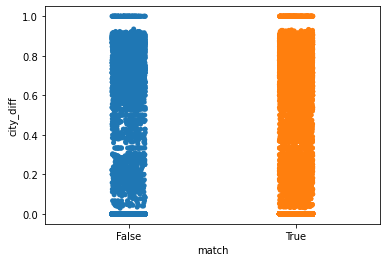

In [ ]:
sns.stripplot(x="match", y="city_diff", data=pairs.loc[pairs.city_diff>=0])
plt.show()

In [ ]:
pairs.loc[(pairs.location_diff<0.01)&(pairs.name_diff<0.1)&(pairs.address_diff==0)&(pairs.city_diff==0)&(pairs.match==False)&(pairs.country_1=='US')][['name_1','name_2','address_1','address_2']]

,name_1,name_2,address_1,address_2
532,Parkview High School Building H,Parkview High School Building C,"998 Cole Dr, Lilburn, GA 30047","998 Cole Dr, Lilburn, GA 30047"
2526,Sprague Lake Rest Area (Westbound),Sprague Lake Rest Area (Eastbound),Interstate 90,Interstate 90
5315,Section 304,Section 305,KeyBank Center,KeyBank Center
5316,Section 304,Section 308,KeyBank Center,KeyBank Center
6259,Facebook 1050 Building 2,Facebook 1050 Building 1,1050 Page Mill Rd,1050 Page Mill Rd
...,...,...,...,...
571522,Conference Room HS 2007,Conference Room HS 2038,Health Information and Translational Science (HS),Health Information and Translational Science (HS)
572791,Mann Center for the Performing Arts,Mann Center for the Performing Arts D Gate,5201 Parkside Ave,5201 Parkside Ave
575350,Pozez Education Center Centennial D,Pozez Education Center Centennial A,1505 SW 8th Ave,1505 SW 8th Ave
576064,UCF Business Administration II (BA2),UCF Business Administration I (BA1),4000 Central Florida Blvd,4000 Central Florida Blvd


### State

### Zip


---

Zip codes are stored as strings in the orginal data.

In [ ]:
pairs['zip_diff'] = pairs.apply(sim_metric,
                          args=('zip_1', 'zip_2'),
                          axis=1)

# PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [ ]:
## Make a pipeline for your PCA
pipe = Pipeline([('scale', StandardScaler()),
                    ('pca', PCA(2))])

feature_col = ['location_diff','name_diff']
#['location_diff','name_diff','address_diff', 'city_diff',	'zip_diff']

pairs_sample = pairs.loc[pairs.location_diff<1]
X_train = pairs_sample[feature_col]

pipe.fit(X_train.values)

fit = pipe.transform(X_train.values)

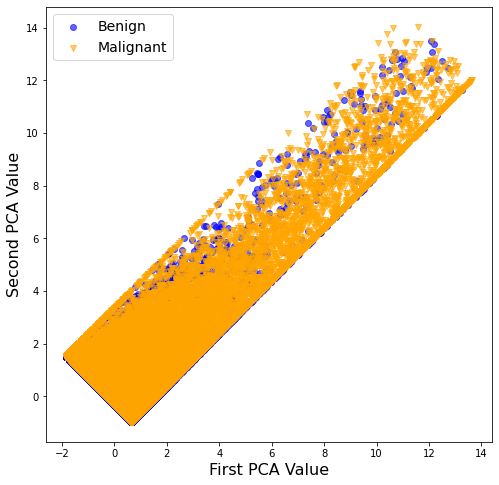

In [ ]:
y_train = pairs_sample['match']

plt.figure(figsize=(8,8))

plt.scatter(fit[y_train==0, 0],
               fit[y_train==0, 1],
               c = 'b',
               alpha = .6,
               label='Benign')

plt.scatter(fit[y_train==1, 0],
               fit[y_train==1, 1],
               c = 'orange',
               marker = 'v',
               alpha = .6,
               label='Malignant')

plt.legend(fontsize=14)

plt.xlabel("First PCA Value", fontsize=16)
plt.ylabel("Second PCA Value", fontsize=16)

plt.show()

# Plotting latitude and longitude


---



In [ ]:
latitude_all = train.latitude.values
longitude_all = train.longitude.values

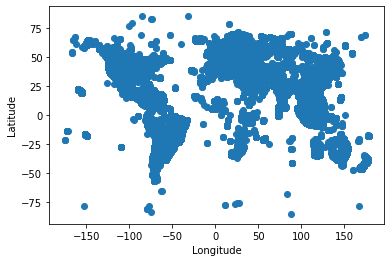

In [ ]:
plt.scatter(longitude_all, latitude_all)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
pairs.iloc[4]

id_1                              E_0000c362229d93
name_1                                  Coffee Cat
latitude_1                                7.082218
longitude_1                             125.610244
address_1                            F. Torres St.
city_1                                  Davao City
state_1                               Davao Region
zip_1                                         8000
country_1                                       PH
url_1                                          NaN
phone_1                                        NaN
categories_1                   Cafés, Coffee Shops
id_2                              E_d52c3c4d53831c
name_2                                   Coffeecat
latitude_2                                7.076016
longitude_2                             125.611457
address_2                     E. Jacinto Extension
city_2                                  Davao City
state_2                               Davao Region
zip_2                          

# Submission

---


In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/Summer 2022/foursquare-location-matching/sample_submission.csv')

In [ ]:
submission

,id,matches
0,E_00001118ad0191,E_00001118ad0191
1,E_000020eb6fed40,E_000020eb6fed40
2,E_00002f98667edf,E_00002f98667edf
3,E_001b6bad66eb98,E_001b6bad66eb98 E_0283d9f61e569d
4,E_0283d9f61e569d,E_0283d9f61e569d E_001b6bad66eb98


In [ ]:
set(test.id).intersection(set(train.id))

{'E_001b6bad66eb98', 'E_0283d9f61e569d'}

In [ ]:
df = train.loc[train.id==test.id[3]]
df.append(train.loc[train.id==test.id[4]])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
434,E_001b6bad66eb98,Foreword Communicatons,1.302216,103.861456,NaN,NaN,NaN,NaN,SG,NaN,NaN,NaN,P_540b73568b0d3c
11033,E_0283d9f61e569d,風雲児 (Fu-unji),35.687101,139.696684,代々木2-14-3,渋谷区,東京都,151-0053,JP,http://www.fu-unji.com,0364138480,Ramen Restaurants,P_fe5531aa3acd9d


In [ ]:
test.columns

Index(['id', 'name', 'latitude', 'longitude', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories'],
      dtype='object')

In [ ]:
test.country

0    MY
1    US
2    RU
3    ID
4    ID
Name: country, dtype: object